# Can SLALOM model Transformer outputs better?

We train models on a linear dataset and compare different surrogate models.
We show quantiative and qualitative results to find out which model is more faithful in representing the output.

## Training models.
The models used in this notebook can be obtained by running
```
./train_models_sparse_bow.sh <run> cuda
```
for ```run``` = 0, 1, 2, 3, 4 (we use five runs for this experiment)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
from transformer_models import DistilBert, DistilGPT2, Bert, Trainer

In [5]:
from transformers import AutoTokenizer

In [16]:
binomial = True
prefix = "models_lin_exp_c"

In [47]:
## Load models
from collections import defaultdict
n_heads = 12
device = "cuda:3"
res_dict = defaultdict(lambda: defaultdict(list))
models_keys = []
model_list = []
for model in ["bert", "distilbert", "distilgpt2"]:
    #res_dict[model] = 
    for run in range(5):
        for n_layers in [1, 2, 6, 12]:
            if "distilgpt2" in model:
                model_obj = DistilGPT2(n_layer=n_layers, n_head=n_heads)
                tokenizer = AutoTokenizer.from_pretrained('distilgpt2', use_fast=True)
            else:
                if model == "bert":
                    model_obj = Bert(n_layers=n_layers, n_heads=n_heads)
                else:
                    model_obj = DistilBert(n_layers=n_layers, n_heads=n_heads)
            
                tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
            model_str = f"{prefix}/r{run}/{model}_trained_{n_layers}_{n_heads}.pt"
            model_obj.model.load_state_dict(torch.load(model_str))
            model_obj.model.eval()
            model_obj.model = model_obj.model.to(device)
            
            ## Now run forward passes
            res = compute_logits_for_single_token(tokenizer, model_obj.model, n_max=30, use_cls="bert" in model,use_device=device)
            res = res[:,:,1]-res[:,:,0]
            res_dict[model][n_layers].append(res) 
            model_list.append(model_obj.model.to("cpu"))
            models_keys.append((model, n_layers, run))
            print(model, n_layers, run)  

bert 1 0
bert 2 0
bert 6 0
bert 12 0
bert 1 1
bert 2 1
bert 6 1
bert 12 1
bert 1 2
bert 2 2
bert 6 2
bert 12 2
bert 1 3
bert 2 3
bert 6 3
bert 12 3
bert 1 4
bert 2 4
bert 6 4
bert 12 4
distilbert 1 0
distilbert 2 0
distilbert 6 0
distilbert 12 0
distilbert 1 1
distilbert 2 1
distilbert 6 1
distilbert 12 1
distilbert 1 2
distilbert 2 2
distilbert 6 2
distilbert 12 2
distilbert 1 3
distilbert 2 3
distilbert 6 3
distilbert 12 3
distilbert 1 4
distilbert 2 4
distilbert 6 4
distilbert 12 4
distilgpt2 1 0
distilgpt2 2 0
distilgpt2 6 0
distilgpt2 12 0
distilgpt2 1 1
distilgpt2 2 1
distilgpt2 6 1
distilgpt2 12 1
distilgpt2 1 2
distilgpt2 2 2
distilgpt2 6 2
distilgpt2 12 2
distilgpt2 1 3
distilgpt2 2 3
distilgpt2 6 3
distilgpt2 12 3
distilgpt2 1 4
distilgpt2 2 4
distilgpt2 6 4
distilgpt2 12 4


In [48]:
len(models_keys)

60

In [49]:
len(model_list)

60

In [20]:
def compute_logits_for_single_token(tokenizer, model, n_max=10, use_cls=True, input_str="perfect", neutral_input="the", use_device="cuda:2"):
    logit_results = []
    cls_tok = torch.tensor([101])
    input_tok = torch.tensor(tokenizer.convert_tokens_to_ids(input_str)).reshape(1)
    neutal_tok = torch.tensor(tokenizer.convert_tokens_to_ids(neutral_input)).reshape(1)
    sep_tok = torch.tensor([102])
    ## Evaluate neutral input
    if use_cls:
        input = torch.cat((cls_tok, neutal_tok, sep_tok))
    else:
        input = neutal_tok
        
    with torch.no_grad():
        logit_score = model(input.reshape(1,-1).to(use_device))["logits"]
        logit_results.append(logit_score.detach().cpu())
        
        x = input_tok
        for i in range(n_max):
            #print(x)
            if use_cls:
                input = torch.cat((cls_tok, x, sep_tok))
            else:
                input = x
            logit_score = model(input.reshape(1,-1).to(use_device))["logits"]
            logit_results.append(logit_score.detach().cpu())
            x = torch.cat((x, input_tok), dim=0)
    return torch.stack(logit_results)

## Explain the models with SLALOM vs Linear vs. GAM

In [103]:
n_samples_offline = 100
def sample_offline_dataset(n_samples_offline, dataset_bert, dataset_gpt, models, model_keys):
    """ 
        Sample a dataset of n_samples_offline synthetic samples from the dataset. These will be used to 
        Evaluate the fit of the model.
        We need two versions of the dataset, due to the different tokenizers of bert and gpt-style models.
        Run all models in the list models and compute the outputs.
    """
    model_scores, true_scores, true_scores_gpt, feature_vects, feature_vects_gpt, labels, labels_gpt = [], [], [], [], [], [], []
    device = "cuda:3"
    batch_size = 64
    mydl_bert, mydl_gpt = DataLoader(dataset_bert, batch_size=batch_size), DataLoader(dataset_gpt, batch_size=batch_size)
    samples_done = 0
    iterator_bert = iter(mydl_bert)
    iterator_gpt = iter(mydl_gpt)
    while samples_done < n_samples_offline: 
        print(samples_done)
        sample_bert, sample_gpt = next(iterator_bert), next(iterator_gpt)
        with torch.no_grad():
            out_list = []
            for m, mkey in zip(models, model_keys):
                m.to(device)
                if "bert" in mkey[0]: 
                    logs = m(sample_bert["input_ids"].to(device), attention_mask = sample_bert["attention_mask"].to(device))["logits"]
                else:
                    logs = m(sample_gpt["input_ids"].to(device), attention_mask = sample_gpt["attention_mask"].to(device))["logits"]
                out_list.append(logs)
                m.to("cpu")
        logs = torch.stack(out_list)
        #print(logs.shape)
        logs = logs[:,:,1]-logs[:,:,0]
        feature_vect_bert = (dataset_bert.word_toks.reshape(1,-1,1) == sample_bert["input_ids"].unsqueeze(1)) # samples 1.
        feature_vect_gpt = (dataset_gpt.word_toks.reshape(1,-1,1) == sample_gpt["input_ids"].unsqueeze(1)) # samples 1.
        feature_vects.append(feature_vect_bert)
        feature_vects_gpt.append(feature_vect_gpt)
        labels.append(sample_bert["label"])
        labels_gpt.append(sample_gpt["label"])
        model_scores.append(logs)
        true_scores.append(sample_bert["gt_score"])
        true_scores_gpt.append(sample_gpt["gt_score"])
        samples_done += batch_size
    labels = torch.cat(labels, dim=0)
    labels_gpt = torch.cat(labels_gpt, dim=0)
    features = torch.cat(feature_vects, dim=0)
    features_gpt = torch.cat(feature_vects_gpt, dim=0)
    true_scores = torch.cat(true_scores, dim=0)
    true_scores_gpt = torch.cat(true_scores_gpt, dim=0)
    model_scores = torch.cat(model_scores, dim=1).t()
    return labels, labels_gpt, features, features_gpt, true_scores, true_scores_gpt, model_scores

In [104]:
from bow_dataset import SparseBoWDataset


words_dict = {"the": (0.2, 0.0), "we": (0.2, 0.0), "movie": (0.2, 0.0), "watch": (0.2, 0.0),
      "best": (0.06, 1.0), "perfect": (0.06, 1.5), "good": (0.08, 0.7),
      "worst": (0.06, -1.5), "poor": (0.06, -1.0),"ok": (0.08, -0.7)}

tokenizer1 = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
myds1 = SparseBoWDataset(tokenizer1, all_words_dict = words_dict, fixed_len=False, binomial_sampling=binomial, ds_length=12000)

tokenizer2 = AutoTokenizer.from_pretrained('distilgpt2', use_fast=True)
myds2 = SparseBoWDataset(tokenizer2, all_words_dict =  words_dict, start_tok=None, end_tok=None, fixed_len=False, binomial_sampling=binomial, ds_length=12000)
    
from torch.utils.data import DataLoader

In [168]:
myds2.cats.probs

tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.0500, 0.0500, 0.0667, 0.0500, 0.0500,
        0.0667])

In [134]:
_, _, features, features_gpt, _, _, model_scores =  sample_offline_dataset(10000, myds1, myds2, model_list, models_keys)
# Model scores [num_models, n_samples]
# Features [n_samples, n_tokens, len_sample]

0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3072
3136
3200
3264
3328
3392
3456
3520
3584
3648
3712
3776
3840
3904
3968
4032
4096
4160
4224
4288
4352
4416
4480
4544
4608
4672
4736
4800
4864
4928
4992
5056
5120
5184
5248
5312
5376
5440
5504
5568
5632
5696
5760
5824
5888
5952
6016
6080
6144
6208
6272
6336
6400
6464
6528
6592
6656
6720
6784
6848
6912
6976
7040
7104
7168
7232
7296
7360
7424
7488
7552
7616
7680
7744
7808
7872
7936
8000
8064
8128
8192
8256
8320
8384
8448
8512
8576
8640
8704
8768
8832
8896
8960
9024
9088
9152
9216
9280
9344
9408
9472
9536
9600
9664
9728
9792
9856
9920
9984


In [135]:
model_scores.shape

torch.Size([10048, 60])

In [149]:
model_scores.shape

torch.Size([10048, 60])

In [144]:
torch.save((features, features_gpt, model_scores), "data/c_feature_scores.pt")

In [136]:
torch.sum(features, dim=-1)[0]

tensor([2, 1, 4, 5, 2, 1, 1, 0, 0, 6])

In [137]:
torch.sum(features_gpt, dim=-1)[0]

tensor([2, 2, 3, 3, 1, 1, 0, 0, 2, 3])

## Fit models: GAM, Linear Model etc.

In [138]:
## Num models to fit.
from sklearn.linear_model import LinearRegression, Lasso
features = features.cpu()
model_scores = model_scores.cpu()
myLRs = []
myGAMs = []
for m, mkey in zip(range(model_scores.shape[1]), models_keys):
    if "bert" in mkey[0]: 
        features_use = features
    else:
        features_use = features_gpt
    myLR = LinearRegression()
    myLR.fit(torch.sum(features_use, dim=-1), model_scores[:, m])
    myLRs.append(myLR)
    myGAM = Lasso(alpha=0.01)
    myGAM.fit(features_use.reshape(len(features_use), -1), model_scores[:,m])
    myGAMs.append(myGAM)

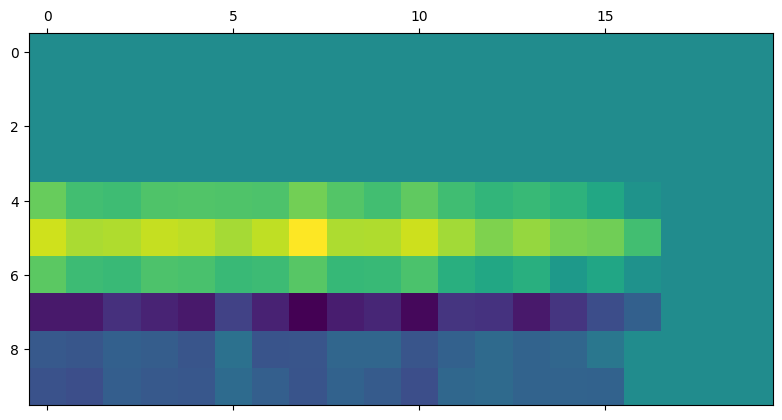

In [139]:
import matplotlib.pyplot as plt
plt.matshow(myGAMs[43].coef_.reshape(10,-1)[:,:20])

## Fit models: SLALOM

In [140]:
from bow_dataset import MyLittleSLALOM
from torch.utils.data import TensorDataset
from torch.optim import Adam
import math
from experiment_utils import fit_slalom_sgd

In [141]:
torch.sum(features, dim=-1).shape

torch.Size([10048, 10])

In [145]:
mySlaloms = []
perform_epochs = 100
for m in range(model_scores.shape[1]):
    print("Fitting model", m)
    if "bert" in models_keys[m][0]:
        _, _, slalom = fit_slalom_sgd(myds1, torch.sum(features, dim=-1), model_scores[:,m].cpu(), num_eps=perform_epochs, use_cls=False)
    else:
        _, _, slalom = fit_slalom_sgd(myds2, torch.sum(features_gpt, dim=-1), model_scores[:,m].cpu(), num_eps=perform_epochs, use_cls=False)
    mySlaloms.append(slalom)

Fitting model 0
10
1.8427059644385926
0.5802535488606887
0.37309240892141937
0.3133700894084009
0.298581164667223
0.294314308105864
0.2928037560296302
0.2921868507867628
0.29190766505037363
0.29177018724011583
Fitting model 1
10
1.406680909999191
0.43537718199917763
0.27811860923711235
0.22449857217827415
0.20658135564678637
0.2004703400356301
0.19828126080680558
0.19752436372919785
0.19734812418302558
0.1974219467652058
Fitting model 2
10
1.8792176177003272
0.5585501593807677
0.37895282970302613
0.3485469658994682
0.34424205805012037
0.34428666227985505
0.3451130351327897
0.34598531897357127
0.3467419528116793
0.3473597773304704
Fitting model 3
10
2.185504657245562
0.7346244956341463
0.5880012788272108
0.5482397489150349
0.5368562969107421
0.5325610868132821
0.5307309195277724
0.5299076624272928
0.5295257917918114
0.5293445917558928
Fitting model 4
10
2.1762350763097356
0.6264929583002303
0.32270394773973604
0.2240665843224263
0.20707145336551422
0.20471039454715664
0.2043077349283613

## Forward random samples and compute errors.

In [150]:
n_samples_test = 500
with torch.no_grad():
    _, _, features_test, features_test_gpt, _, _, model_scores_test =  sample_offline_dataset(n_samples_test, myds1, myds2, model_list, models_keys)

0
64
128
192
256
320
384
448


In [151]:
model_scores_test.shape

torch.Size([512, 60])

In [152]:
def forward_samples(features, model_lr, model_gam, model_slalom, use_cls=True):
    score_lin = model_lr.predict(torch.sum(features, dim=-1))
    score_gam = model_gam.predict(features.reshape(len(features),-1))
    if use_cls:
        ext_feat = torch.cat((torch.sum(features, dim=-1), torch.ones(len(features), 2)), dim=1)
    else:
        ext_feat = torch.sum(features, dim=-1)
    score_slalom = model_slalom.forward_feature_vects(ext_feat)[:,1].detach().cpu()
    return score_lin, score_gam, score_slalom

In [157]:
lin_all_rnd = {}
gam_all_rnd = {}
slalom_all_rnd = {}
true_all_rnd = {}
for m in range(len(models_keys)):
    use_cls=False
    if "bert" in models_keys[m][0]:
        score_lin, score_gam, score_slalom = forward_samples(features_test, myLRs[m], myGAMs[m], mySlaloms[m], use_cls=use_cls)
    else:
        score_lin, score_gam, score_slalom = forward_samples(features_test_gpt, myLRs[m], myGAMs[m], mySlaloms[m], use_cls=use_cls)
    lin_all_rnd[models_keys[m]] = torch.tensor(score_lin) # Pred of linear model
    gam_all_rnd[models_keys[m]] = torch.tensor(score_gam) # Pred of GAM
    slalom_all_rnd[models_keys[m]] = score_slalom # Pred of SLALOM
    true_all_rnd[models_keys[m]] = model_scores_test[:,m].flatten().cpu() # Pred of transformer model.

In [158]:
true_all_rnd.keys()

dict_keys([('bert', 1, 0), ('bert', 2, 0), ('bert', 6, 0), ('bert', 12, 0), ('bert', 1, 1), ('bert', 2, 1), ('bert', 6, 1), ('bert', 12, 1), ('bert', 1, 2), ('bert', 2, 2), ('bert', 6, 2), ('bert', 12, 2), ('bert', 1, 3), ('bert', 2, 3), ('bert', 6, 3), ('bert', 12, 3), ('bert', 1, 4), ('bert', 2, 4), ('bert', 6, 4), ('bert', 12, 4), ('distilbert', 1, 0), ('distilbert', 2, 0), ('distilbert', 6, 0), ('distilbert', 12, 0), ('distilbert', 1, 1), ('distilbert', 2, 1), ('distilbert', 6, 1), ('distilbert', 12, 1), ('distilbert', 1, 2), ('distilbert', 2, 2), ('distilbert', 6, 2), ('distilbert', 12, 2), ('distilbert', 1, 3), ('distilbert', 2, 3), ('distilbert', 6, 3), ('distilbert', 12, 3), ('distilbert', 1, 4), ('distilbert', 2, 4), ('distilbert', 6, 4), ('distilbert', 12, 4), ('distilgpt2', 1, 0), ('distilgpt2', 2, 0), ('distilgpt2', 6, 0), ('distilgpt2', 12, 0), ('distilgpt2', 1, 1), ('distilgpt2', 2, 1), ('distilgpt2', 6, 1), ('distilgpt2', 12, 1), ('distilgpt2', 1, 2), ('distilgpt2', 2, 2

In [159]:
torch.save((lin_all_rnd, gam_all_rnd, slalom_all_rnd, true_all_rnd), f"data/exp_c.pt")

In [166]:
import numpy as np
n_runs = 5
lin_all, gam_all, slalom_all, true_all = torch.load(f"data/exp_c.pt")
for i, (model_arch, model_arch_str) in enumerate(zip(["distilgpt2", "distilbert", "bert"], ["GPT-2", "DistilBERT", "BERT"])):
    for layers in [1, 2, 6, 12]:
        res_str = f"{model_arch_str} & {layers} & "
        for model, scores_use in zip(["linear", "GAM", "SLALOM"], [lin_all, gam_all, slalom_all]):
            res_list = []
            for r in range(n_runs): 
                key = (model_arch, layers, r)
                res_list.append(torch.mean((scores_use[key]-true_all[key]).pow(2)).item()*100)
            narr = np.array(res_list)
            if model != "SLALOM":
                res_str += r"\wstd{"+ f"{narr.mean():.2f}"+  r"}{" + f"{narr.std()/math.sqrt(n_runs):.2f}" +r"} & "
            else:
                res_str += r"\bwstd{"+ f"{narr.mean():.2f}"+  r"}{" + f"{narr.std()/math.sqrt(n_runs):.2f}" +r"} \\"
        print(res_str)
    print(r"\midrule")

GPT-2 & 1 & \wstd{20.31}{2.02} & \wstd{48.78}{2.70} & \bwstd{16.92}{1.33} \\
GPT-2 & 2 & \wstd{24.81}{3.11} & \wstd{54.33}{3.26} & \bwstd{22.17}{1.98} \\
GPT-2 & 6 & \wstd{32.66}{7.60} & \wstd{57.08}{7.19} & \bwstd{21.59}{4.14} \\
GPT-2 & 12 & \wstd{25.74}{4.18} & \wstd{54.36}{3.94} & \bwstd{20.25}{2.37} \\
\midrule
DistilBERT & 1 & \wstd{28.28}{4.30} & \wstd{44.43}{2.22} & \bwstd{10.83}{2.13} \\
DistilBERT & 2 & \wstd{32.58}{7.75} & \wstd{53.87}{7.20} & \bwstd{16.82}{4.38} \\
DistilBERT & 6 & \wstd{31.49}{4.06} & \wstd{49.35}{3.13} & \bwstd{17.26}{3.64} \\
DistilBERT & 12 & \wstd{50.82}{9.21} & \wstd{71.64}{9.19} & \bwstd{27.50}{4.18} \\
\midrule
BERT & 1 & \wstd{26.33}{1.90} & \wstd{43.30}{0.88} & \bwstd{7.34}{0.70} \\
BERT & 2 & \wstd{28.43}{3.75} & \wstd{48.28}{3.23} & \bwstd{9.92}{1.19} \\
BERT & 6 & \wstd{50.82}{6.34} & \wstd{68.23}{4.59} & \bwstd{23.99}{3.38} \\
BERT & 12 & \wstd{44.58}{13.15} & \wstd{51.38}{14.71} & \bwstd{18.77}{6.78} \\
\midrule


## Compute the qualitative results.

In [181]:
def forward_other_models_for_single_token(tokenizer, model_lr, model_gam, model_slalom, token_list, n_max=10, input_str="perfect", neutral_input="the", sample_len=30, offset=0):
    logit_results = []
    input_tok = torch.tensor(tokenizer.convert_tokens_to_ids(input_str)).reshape(1)
    neutal_tok = torch.tensor(tokenizer.convert_tokens_to_ids(neutral_input)).reshape(1)
    score_lin, score_gam, score_slalom = [], [], []
    
    ## Evaluate neutral input
    
    input_pad = torch.zeros(sample_len)
    input_pad[offset] = neutal_tok
    input_to_features =  (token_list.reshape(-1,1) == input_pad.unsqueeze(0))
    #print(input_to_features.shape)
    
    score_lin.append(model_lr.predict(torch.sum(input_to_features, dim=-1).reshape(1,-1))[0])
    score_gam.append(model_gam.predict(input_to_features.reshape(1,-1))[0])
    
    ext_feat = torch.sum(input_to_features, dim=-1).reshape(1,-1)
    score_slalom.append(model_slalom.forward_feature_vects(ext_feat)[0,1].item())

    with torch.no_grad():
        input = input_tok
        for i in range(n_max):
            input_pad = torch.zeros(sample_len)
            input_pad[offset:len(input)+offset] = input
            input_to_features =  (token_list.reshape(-1,1) == input_pad.unsqueeze(0))
            #print(input_to_features.shape)
            
            score_lin.append(model_lr.predict(torch.sum(input_to_features, dim=-1).reshape(1,-1))[0])
            score_gam.append(model_gam.predict(input_to_features.reshape(1,-1))[0])
            ext_feat = torch.sum(input_to_features, dim=-1).reshape(1,-1)
            score_slalom.append(model_slalom.forward_feature_vects(ext_feat)[0,1].item())
            
            input = torch.cat((input, input_tok), dim=0)  
    return score_lin, score_gam, score_slalom

In [213]:
lin_all = {}
gam_all = {}
slalom_all = {}
true_all = {}
for m in range(len(models_keys)):
    if "bert" in models_keys[m][0]:
        score_lin, score_gam, score_slalom = forward_other_models_for_single_token(tokenizer1, myLRs[m], myGAMs[m], mySlaloms[m], myds1.word_toks, n_max=30, sample_len = 32, offset=1)
    else:
        score_lin, score_gam, score_slalom = forward_other_models_for_single_token(tokenizer2, myLRs[m], myGAMs[m], mySlaloms[m], myds2.word_toks, n_max=30, sample_len = 30)
    lin_all[models_keys[m]] = torch.tensor(score_lin)
    gam_all[models_keys[m]] = torch.tensor(score_gam)
    slalom_all[models_keys[m]] = torch.tensor(score_slalom)
    true_all[models_keys[m]] = res_dict[models_keys[m][0]][models_keys[m][1]][models_keys[m][2]].flatten()

In [197]:
models_keys[1]

('bert', 2, 0)

In [198]:
gam_all.keys()

dict_keys([('bert', 1, 0), ('bert', 2, 0), ('bert', 6, 0), ('bert', 12, 0), ('bert', 1, 1), ('bert', 2, 1), ('bert', 6, 1), ('bert', 12, 1), ('bert', 1, 2), ('bert', 2, 2), ('bert', 6, 2), ('bert', 12, 2), ('bert', 1, 3), ('bert', 2, 3), ('bert', 6, 3), ('bert', 12, 3), ('bert', 1, 4), ('bert', 2, 4), ('bert', 6, 4), ('bert', 12, 4), ('distilbert', 1, 0), ('distilbert', 2, 0), ('distilbert', 6, 0), ('distilbert', 12, 0), ('distilbert', 1, 1), ('distilbert', 2, 1), ('distilbert', 6, 1), ('distilbert', 12, 1), ('distilbert', 1, 2), ('distilbert', 2, 2), ('distilbert', 6, 2), ('distilbert', 12, 2), ('distilbert', 1, 3), ('distilbert', 2, 3), ('distilbert', 6, 3), ('distilbert', 12, 3), ('distilbert', 1, 4), ('distilbert', 2, 4), ('distilbert', 6, 4), ('distilbert', 12, 4), ('distilgpt2', 1, 0), ('distilgpt2', 2, 0), ('distilgpt2', 6, 0), ('distilgpt2', 12, 0), ('distilgpt2', 1, 1), ('distilgpt2', 2, 1), ('distilgpt2', 6, 1), ('distilgpt2', 12, 1), ('distilgpt2', 1, 2), ('distilgpt2', 2, 2

In [215]:
torch.save((lin_all, gam_all, slalom_all, true_all), f"data/exp_c_final.pt")

In [189]:
import matplotlib.pyplot as plt

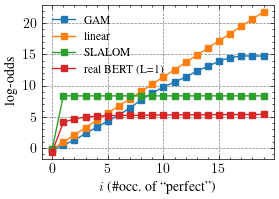

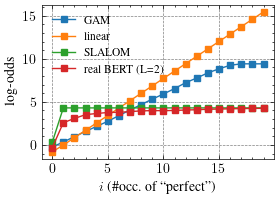

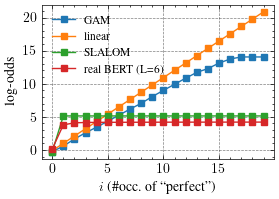

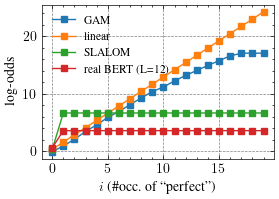

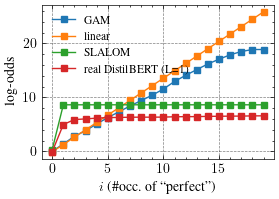

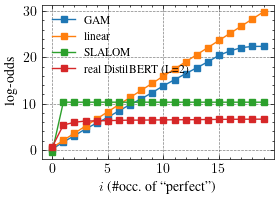

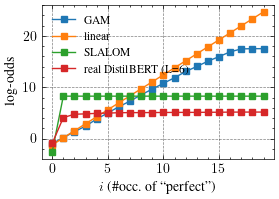

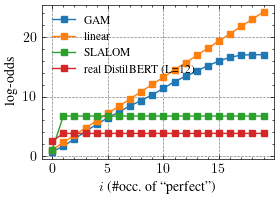

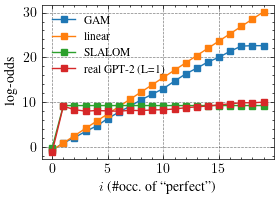

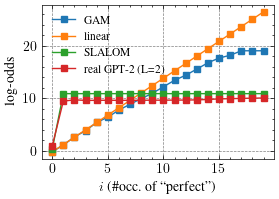

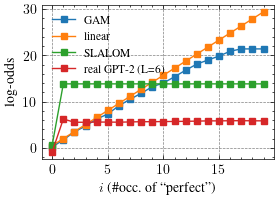

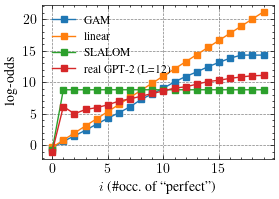

In [217]:
## Create the figures nicely.
plt.style.use('./figures/matplot.mplstyle')
transformer_plot_keys = {"bert": "BERT", "distilbert": "DistilBERT", "distilgpt2": "GPT-2"}
pts_lim = 20
marker_sz = 4
run = 0
for i, model_arch in enumerate(["bert", "distilbert", "distilgpt2"]):
    #lin_all, gam_all, slalom_all, true_all = torch.load(f"data/exp_b_{model_arch}.pt")
    for layers in [1, 2, 6, 12]:
        f, ax = plt.subplots()
        key = (model_arch, layers, run)
        plt.plot(gam_all[key][:pts_lim], "-s", label="GAM", markersize=marker_sz)
        ax.plot(lin_all[key][:pts_lim], "-s", label="linear", markersize=marker_sz)
        ax.plot(slalom_all[key][:pts_lim], "-s", label="SLALOM", markersize=marker_sz)
        ax.plot(true_all[key][:pts_lim], "-s", label = f"real {transformer_plot_keys[model_arch]} (L={layers})", markersize=marker_sz)
        ax.legend(fontsize="small")
        ax.set_ylabel("log-odds")
        ax.set_xlabel(r"$i$ (\#occ. of ``perfect'')")
        f.set_size_inches(3, 2)
        #f.savefig(f"figures/C_lines_{model_arch}_{layers}.pdf")

## Now forward Random Features.

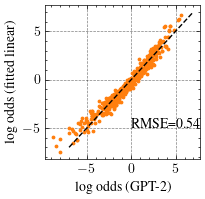

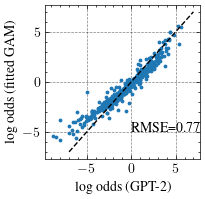

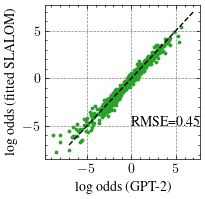

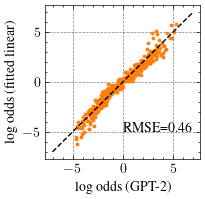

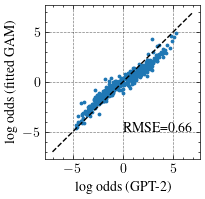

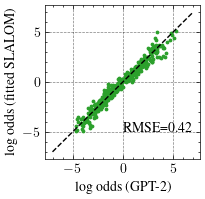

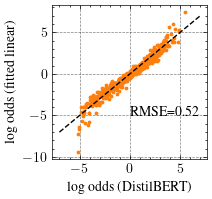

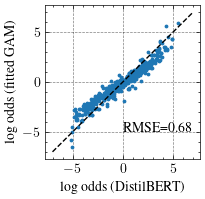

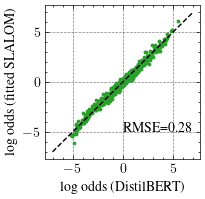

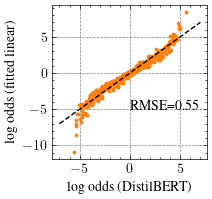

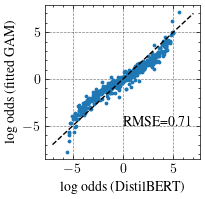

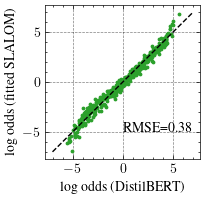

In [220]:
plt.style.use('./figures/matplot.mplstyle')
transformer_plot_keys = {"bert": "BERT", "distilbert": "DistilBERT", "distilgpt2": "GPT-2"}
colors_models = {"linear": "tab:orange", "GAM": "tab:blue", "SLALOM": "tab:green"}
pts_lim = 20
sz = 3
lim = 7.0
run = 0
for i, model_arch in enumerate(["distilgpt2", "distilbert"]):
    lin_all, gam_all, slalom_all, true_all = torch.load(f"data/exp_c.pt")
    for layers in [1, 2]:
        for model, scores_use in zip(["linear", "GAM", "SLALOM"], [lin_all, gam_all, slalom_all]):
            f, ax = plt.subplots()
            # Calculate and print rmse
            key = (model_arch, layers, run)
            ax.plot([-lim, lim], [-lim, lim], "--k")
            ax.scatter(true_all[key], scores_use[key], sz, c=colors_models[model])
            ax.set_xlabel(f"log odds ({transformer_plot_keys[model_arch]})")
            ax.set_ylabel(f"log odds (fitted {model})")
            #ax.set_xlim([-lim, lim])
            #ax.set_ylim([-lim, lim])
            mse = torch.sqrt(torch.mean((scores_use[key]-true_all[key]).pow(2)))
            ax.text(0,-lim+2, s=f"RMSE={mse.item():.2f}")
            f.set_size_inches(2, 2)
            #f.savefig(f"figures/C_scatter_{model_arch}_{layers}_{model}.pdf")